## Image Classification 

### Importing libraries

In [188]:
import numpy as np 
import pandas as pd
import matplotlib.image as plt_img
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [18, 16]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['font.size'] = 14

### Data preprocessing

In [189]:
# Images are separated respectively upon the 4 channels (RBGI:Red-Green-Blue-Intensity)
# Images are part of training data 

# Get coordinates from files 
# Coordinates are used to get the pixelwise values of each channel(RGBI) w.r.t the class(River and Non-River)
cws_path = '05-image-classification/dataset'
data_river = pd.read_csv('dataset/river.txt', sep=" ", usecols=[0,1],  names=["x_coordinate", "y_coordinate"], header=None)
data_non_river = pd.read_csv('dataset/non_river.txt', sep=" ", usecols=[0,1],  names=["x_coordinate", "y_coordinate"], header=None)
# Map coordinates in a list 
x_river = list(map(int, data_river["x_coordinate"]))
y_river = list(map(int, data_river["y_coordinate"]))
x_non_river = list(map(int, data_non_river["x_coordinate"]))
y_non_river = list(map(int, data_non_river["y_coordinate"]))

# Get a matrix of each image in each channel upon each channel's file
mat_img_R = plt_img.imread('dataset/band1(R).png')
mat_img_G = plt_img.imread('dataset/band2(G).png')
mat_img_B = plt_img.imread('dataset/band3(B).png')
mat_img_I = plt_img.imread('dataset/band4(I).png')

# Read Ground_truth image 
mat_img_GT = plt_img.imread('dataset/ground_truth.png')

# Place holders  
x_riv_R = []
x_riv_B = []
x_riv_G = []
x_riv_I = []
x_non_riv_R = []
x_non_riv_B = []
x_non_riv_G = []
x_non_riv_I = []

# Extract coordinates values for class River refered from the coordinates given within the .txt file
for x_r, y_r in zip(x_river, y_river): 
    x_riv_R.append(mat_img_R[x_r, y_r])
    x_riv_G.append(mat_img_G[x_r, y_r])
    x_riv_B.append(mat_img_B[x_r, y_r])
    x_riv_I.append(mat_img_I[x_r, y_r])
# Extract coordinates values for class Non-River refered from the coordinates given within the .txt file
for x_r, y_r in zip(x_non_river, y_non_river): 
    x_non_riv_R.append(mat_img_R[x_r, y_r])
    x_non_riv_G.append(mat_img_G[x_r, y_r])
    x_non_riv_B.append(mat_img_B[x_r, y_r])
    x_non_riv_I.append(mat_img_I[x_r, y_r])
    
# Create Class Label for our 2 classes {River and Non-River}
y_river = np.ones((len(x_river),) , dtype=int)
y_non_river = np.zeros((len(x_non_river),) , dtype=int)

# Create the Column Label 
y = np.concatenate((y_river, y_non_river) , axis=None)

# Create Pandas Dataframe for Training data
# Each Column represents a channel which is a feature   
dataset_dict = {
        'Red': x_riv_R + x_non_riv_R,
        'Green' : x_riv_G + x_non_riv_G,
        'Blue' : x_riv_B + x_non_riv_B,
        'Intensity' : x_riv_I + x_non_riv_I,
        'Label' : y
}

# The final dataset 
dataset = pd.DataFrame(dataset_dict)
#dataset.head()

# Suffle the dataset 
dataset = dataset.sample(frac=0.8).reset_index(drop=True)
#dataset.head()

### Training 

In [190]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
X_train = dataset.iloc[:,:4].values
y_train = dataset.iloc[:,4:].values

model = GaussianNB()
model.fit(X_train, np.ravel(y_train))

GaussianNB(priors=None, var_smoothing=1e-09)

### Testing 

PRIOR PROBABILITY : [0.6557377 0.3442623]
ACCURACY : 99.7482 %


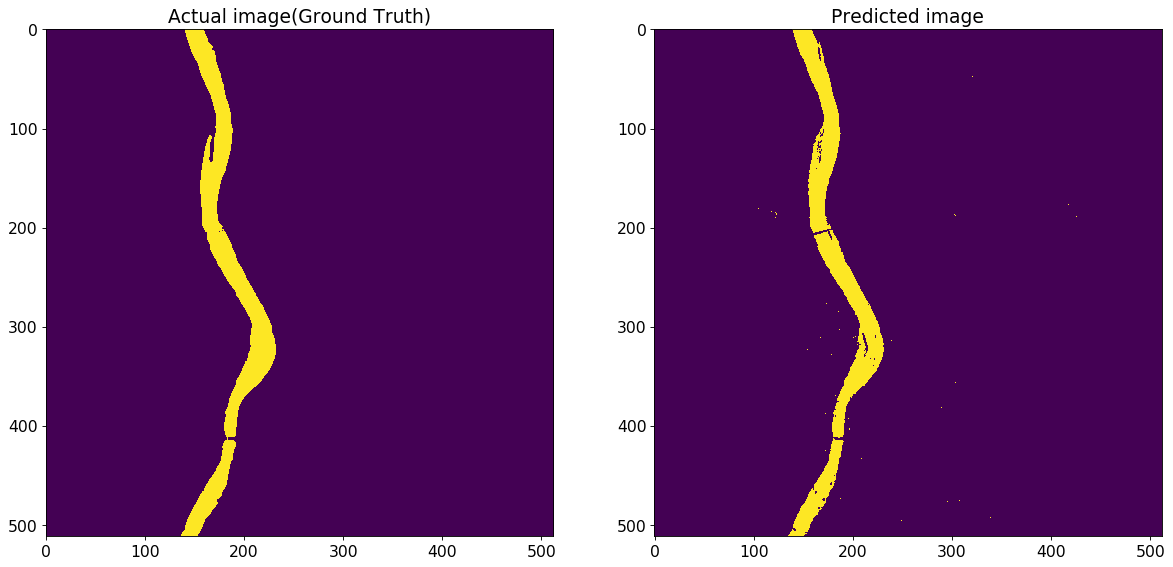

In [191]:
# the same dataset given by images channels used previously are used for Tesing purpose 
X_test = np.array([mat_img_R.ravel(), mat_img_G.ravel(), mat_img_B.ravel(), mat_img_I.ravel()]).T
y_test = mat_img_GT.ravel()

# data prediction 
y_predict = model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
#print(accuracy)

print('PRIOR PROBABILITY : {}'.format(model.class_prior_))
print('ACCURACY : {:05.4f} %'.format(accuracy*100))

# Get the Goung_truth and the Predict images
ground_truth_image = mat_img_GT
predicted_image = np.reshape(y_predict, (512, 512))

# Ploting the the Actual Image and the Predicted Image 
fig = plt.figure()
actual_fig = fig.add_subplot(1,2,1)
actual_fig.set_title('Actual image(Ground Truth)')
plt.imshow(ground_truth_image)
predict_fig = fig.add_subplot(1,2,2)
predict_fig.set_title('Predicted image')
plt.imshow(predicted_image)
plt.show()

### Testing for different Prior Probabilities 

In [192]:
# prior_c1: Prior Proba for Class = C1(River) 
# prior_c2: Proba for Class = C2(Non_River)
prior_c1 = 0.0005
prior_c2 = 0.9995

# Initializing data for Pandas Dataframe showing the results for different Prior Probabilities and their effet on Accuracy
prior_probabilities = []
n_miss_predicted = []
n_true_predicted = []
n_accuracy = []

while (prior_c1 <= 1):
    model = GaussianNB(priors=[prior_c1, prior_c2])
    model.fit(X_train, np.ravel(y_train))
    y_predict = model.predict(X_test)
    mis_predicted = [1 for x, y in zip(y_predict, y_test) if x != y]
    true_predicted = [1 for x, y in zip(y_predict, y_test) if x == y]
    accuracy = accuracy_score(y_predict, y_test)
    prior_probabilities.append(['{:05.4f}'.format(prior_c1), '{:05.4f}'.format(prior_c2)])
    n_miss_predicted.append(len(mis_predicted))
    n_true_predicted.append(len(true_predicted))
    n_accuracy.append('{:05.4f} %'.format(accuracy*100))
    # Increment 0.05 the Prior Proba of Class=C1(River) and decrement 0.05 for Class=C2(Non_River)
    prior_c1 += 0.05
    prior_c2 -= 0.05

# Create Pandas Dataframe for showing results 
results_data_frame = {
    'PRIOR PROBA': prior_probabilities,
    'TRUE PREDICTED' : n_true_predicted,
    'MISPREDICTED' : n_miss_predicted,
    'ACCURACY' : n_accuracy
}

pd_results_data_frame = pd.DataFrame(results_data_frame)
# Print Results dataframe
print(pd_results_data_frame)


         PRIOR PROBA  TRUE PREDICTED  MISPREDICTED   ACCURACY
0   [0.0005, 0.9995]          259685          2459  99.0620 %
1   [0.0505, 0.9495]          261257           887  99.6616 %
2   [0.1005, 0.8995]          261280           864  99.6704 %
3   [0.1505, 0.8495]          261321           823  99.6861 %
4   [0.2005, 0.7995]          261423           721  99.7250 %
5   [0.2505, 0.7495]          261471           673  99.7433 %
6   [0.3005, 0.6995]          261472           672  99.7437 %
7   [0.3505, 0.6495]          261467           677  99.7417 %
8   [0.4005, 0.5995]          261460           684  99.7391 %
9   [0.4505, 0.5495]          261454           690  99.7368 %
10  [0.5005, 0.4995]          261459           685  99.7387 %
11  [0.5505, 0.4495]          261447           697  99.7341 %
12  [0.6005, 0.3995]          261481           663  99.7471 %
13  [0.6505, 0.3495]          261482           662  99.7475 %
14  [0.7005, 0.2995]          261503           641  99.7555 %
15  [0.7